# Analyzing The Demand for Cars

In this notebook we will see how to upload the data and explore it using tools we developed in the previous projects and using simple linear regression analysis.

In this notebook we also look at the following topics:
1. how to take a function of a column in a DataFrame, both for categorical variables (vehicle type) and for continuous variables (e.g. price).
2. How to add more bells and whistles to the plots.

## Packages used

In [2]:
# Packages used

#to upload the data:
import requests, json 

#for plotting:
import matplotlib.pyplot as plt 

# Dataframes and math:
import numpy as np
import pandas as pd
import math

# K-means clustering
from sklearn.cluster import KMeans

# For linear regression
import statsmodels.formula.api as smf

In [3]:
#pip install statsmodels

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

## Uploading the data

I created a JSON version of the 1996 data on car sales. It is put on my Github page.

In [89]:
url = "https://raw.githubusercontent.com/ArieBeresteanu/Econ1923_Fall2022/main/Demand%20Estimation/cardata1996.json"
res = requests.get(url).json()
cars = pd.DataFrame(res)

In [7]:
n_cars, n_cols = cars.shape

print(f"The data contains information on {n_cars} cars and it has {n_cols} columns.")

The data contains information on 185 cars and it has 17 columns.


In [8]:
cars.head()

,car,year,firm_id,firm_name,division,model,segm1,Quantity,Price,wheel_base,length,width,weight,disp,hp,mpg_city,mpg_highway
0,0,1996,3,HONDA,Acura,SLX,32,2565,34320,108.7,178.9,72.4,4315,3.2,190,14,18
1,0,1996,19,GM,Chevrolet,Astro,21,125962,19152,110.0,189.8,77.5,3398,4.3,190,17,22
2,0,1996,19,GM,Chevrolet,Blazer,32,246307,17406,107.0,176.8,65.4,3365,4.3,165,16,21
3,0,1996,19,GM,Chevrolet,Express/VAN,22,80203,21987,135.0,218.7,79.2,4641,4.3,195,15,19
4,0,1996,19,GM,Chevrolet,S10,41,190178,10125,108.3,178.2,64.7,2773,2.2,118,23,28


**Note:** ```disp``` measures engine displacement and is expressed in liters.

>Engine displacement is the measure of the cylinder volume swept by all of the pistons of a piston engine, excluding the combustion chambers.

In [10]:
cars['category'] = cars['segm1'].map(lambda x: math.floor((x)/10))

## Descriptive Statistics

To expand our Python skills let's look at _lambda_ functions and demonstrate their use to create labels.

In [12]:
# using an explicit function 

def carLabel(x):
    if x==1:
        return 'Passenger Car'
    else:
        return 'SUV/Truck/mini Van'

cars['car_Cat'] = cars['car'].map(lambda x: carLabel(x))

carCat = pd.crosstab(index=cars['car_Cat'], columns='count')
carCat


col_0,count
car_Cat,
Passenger Car,123
SUV/Truck/mini Van,62


In [13]:
# using a dictionary

categoryDict = {
    '0': 'passenger cars',
    '2': 'minivans',
    '3': 'SUV',
    '4': 'light trucks'   
}
cars['categoryName'] = cars['category'].map(lambda x: categoryDict[str(x)])

carCat = pd.crosstab(index=cars['categoryName'], columns='count')
carCat

col_0,count
categoryName,
SUV,28
light trucks,13
minivans,21
passenger cars,123


In [14]:
pd.crosstab(index=cars['category'], columns='count')

col_0,count
category,
0,123
2,21
3,28
4,13


## Product differentiation

How differentiated are cars from each other?

In [16]:
categoryColor = {
    '0': 'green',
    '2': 'blue',
    '3': 'red',
    '4': 'yellow'
}
cars['categoryColor'] = cars['category'].map(lambda x: categoryColor[str(x)])

In [17]:
# Text for box

t = ' Green - Passenger Cars \n Blue - Minivans \n Red - SUVs \n Yellow - Light Trucks'

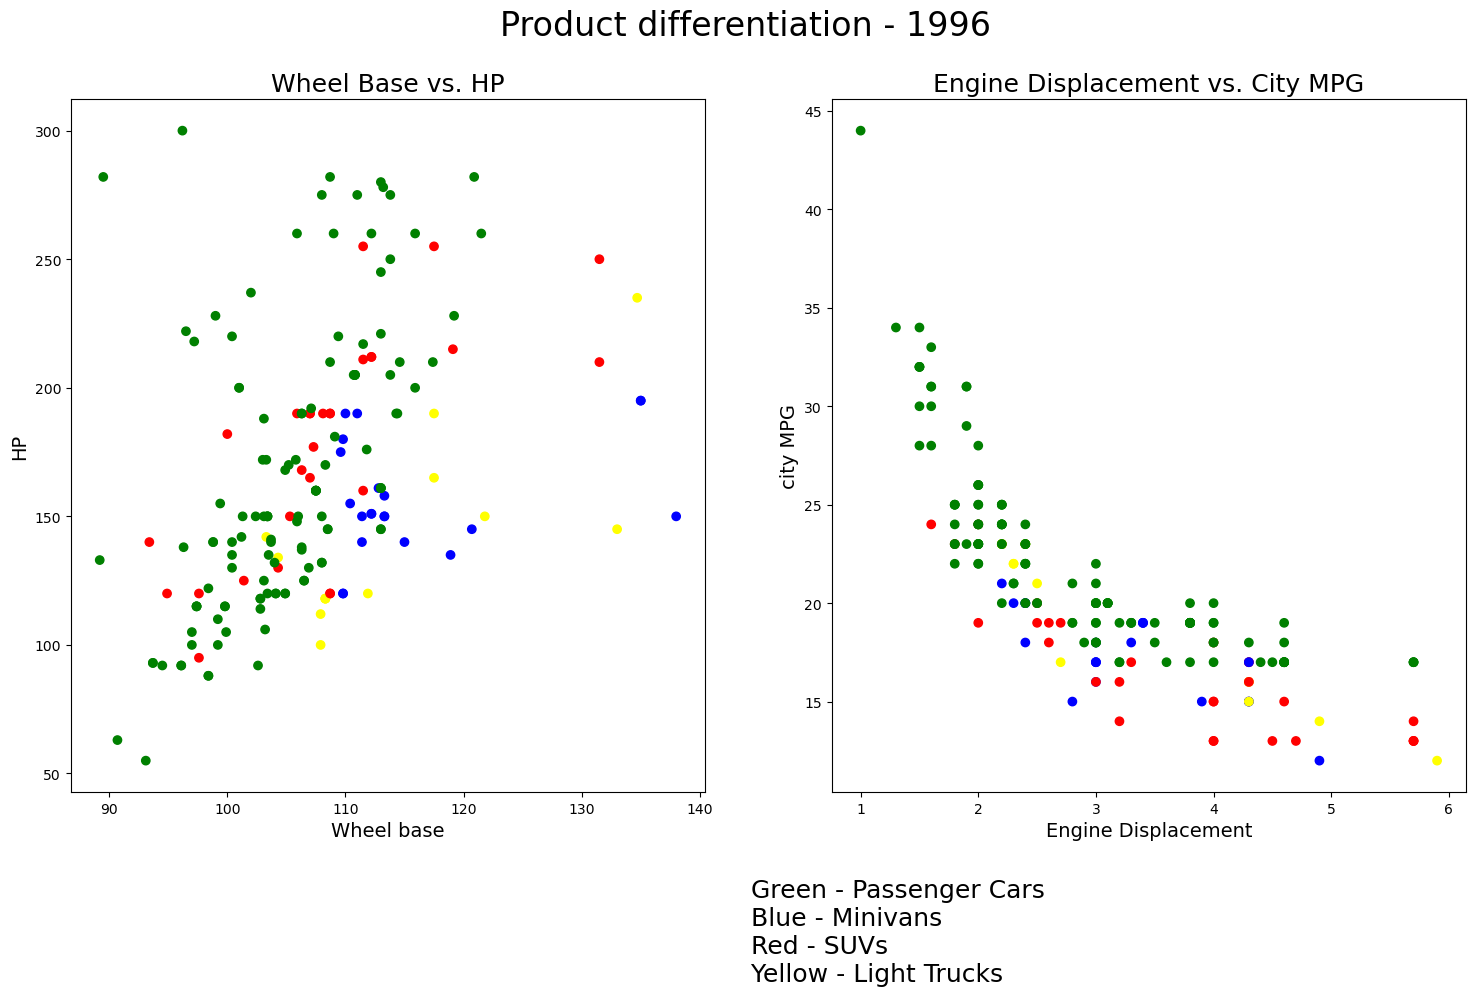

In [18]:
fig, axs = plt.subplots(1, 2, squeeze=False, figsize=(18,9)) # ,                        subplot_kw = dict(polar = True))

axs[0,0].scatter(cars['wheel_base'], cars['hp'], c=cars['categoryColor'])
axs[0,0].set_title("Wheel Base vs. HP", fontsize=18)
axs[0,0].set_xlabel("Wheel base", fontsize=14)
axs[0,0].set_ylabel("HP", fontsize=14)

axs[0,1].scatter(cars['disp'], cars['mpg_city'], c=cars['categoryColor'])
axs[0,1].set_title("Engine Displacement vs. City MPG", fontsize=18)
axs[0,1].set_xlabel("Engine Displacement", fontsize=14)
axs[0,1].set_ylabel("city MPG", fontsize=14)
axs[0,1].text(0, 1, t, ha='left', rotation=0, fontsize=18,wrap=True)


fig.suptitle('Product differentiation - 1996', fontsize=24)
plt.show()

## Clustering

Let's look more carefully at wheel_base versus HP using K-means clustering. We first bring the scaling functions from the previous project.

In [20]:
def rescaleFeatures(df_in):
    """
    Rescale all columns in the dataframe to the [0, 1] interval.
    Returns the scaled dataframe, and Series of original column-wise min and max.
    """
    df_out = df_in.copy().astype(float)  # Ensure float dtype to avoid dtype warnings
    m = df_out.min()
    M = df_out.max()
    
    for i in range(len(df_out.columns)):
        df_out.iloc[:, i] = (df_out.iloc[:, i] - m.iloc[i]) / (M.iloc[i] - m.iloc[i])
    
    return df_out, m, M

In [21]:
def upscaleCentroids(centroids_in, m, M):
    """
    Rescales KMeans centroids from [0,1] scaled space back to original feature space.
    Assumes centroids_in is a list of lists or a 2D numpy array.
    """
    import numpy as np
    centroid_out = np.array(centroids_in, dtype=float)  # ensure float
    
    n_centroids = centroid_out.shape[0]
    n_features = centroid_out.shape[1]
    
    for i in range(n_centroids):
        for j in range(n_features):
            centroid_out[i, j] = centroid_out[i, j] * (M.iloc[j] - m.iloc[j]) + m.iloc[j]
    
    return centroid_out

In [22]:
features = ['wheel_base', 'hp']
small_df = cars[features]

df1,m,M = rescaleFeatures(small_df)

inertia = []
n_clusters = []
for i in range(1,13):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0).fit(df1)
    inertia.append(kmeans.inertia_)
    n_clusters.append(i)

#small_df = cars[features]

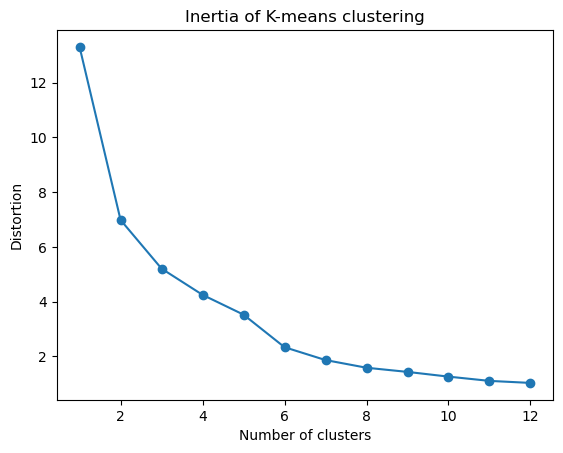

In [23]:
plt.plot(n_clusters,inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Inertia of K-means clustering")
plt.show()

No clear "elbow". I am choosing ```k=5```.

In [25]:
k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(df1)

centroids1 = upscaleCentroids(kmeans.cluster_centers_,m,M)

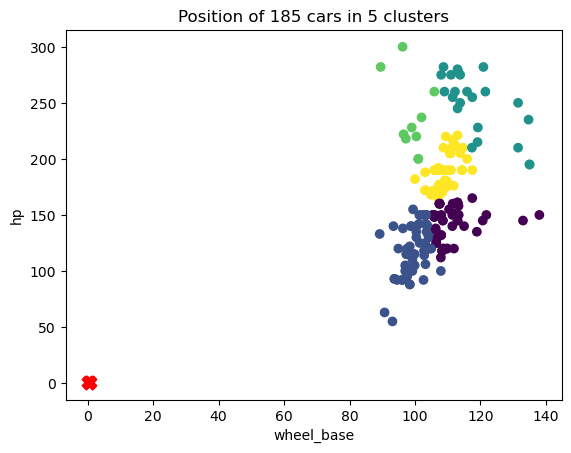

In [26]:
#scatter plot for the dataset
plt.scatter(data=small_df, x=features[0], y=features[1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],marker="X", c="r", s=80, label="centroids")
plt.title(f"Position of {n_cars} cars in {k} clusters")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

## Linear Regression

It's time to estimate some models that connext an outcome variables to some explanatory variables.

<p STYLE="text-align:center;color:red;font-size:24px;"> Warning: The following regressions are <b>WRONG</b> from an economic point of view!!! </p>

Note: I will be ignoring the ```weight``` variable for not special reason (other than forgetting it).

In [30]:
model1 = smf.ols(formula='Price ~  hp + disp + mpg_city + mpg_highway + width + length',data=cars).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     59.21
Date:                Mon, 26 May 2025   Prob (F-statistic):           7.18e-40
Time:                        00:18:43   Log-Likelihood:                -1902.9
No. Observations:                 185   AIC:                             3820.
Df Residuals:                     178   BIC:                             3842.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.663e+04   1.68e+04      1.589      

Let's look at the notes at the end. First, the covariance matrix. We advocate in _Econ 1150_ (or should advocate) the use of heteroscedastic robust standard errors. The following option put inside ```fit()``` will make sure that this is the case.

In [32]:
model1 = smf.ols(formula='Price ~ hp + disp + mpg_city + mpg_highway + width + length',data=cars).fit(cov_type='HC1')

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     33.70
Date:                Mon, 26 May 2025   Prob (F-statistic):           5.50e-27
Time:                        00:18:44   Log-Likelihood:                -1902.9
No. Observations:                 185   AIC:                             3820.
Df Residuals:                     178   BIC:                             3842.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.663e+04   1.32e+04      2.017      

Much better!

Using heteroscedastic robust does not change the estimators for the coefficients but it change their standard errors, t statas and CIs (to the correct ones).

Next, let's look at the possibility of multi-colinearity:

In [35]:
characteristics =['hp', 'disp', 'mpg_city', 'mpg_highway', 'width', 'length']
cars[characteristics].corr()

,hp,disp,mpg_city,mpg_highway,width,length
hp,1.000000,0.818906,-0.695023,-0.533925,0.574293,0.584118
disp,0.818906,1.000000,-0.795537,-0.672615,0.770376,0.730169
mpg_city,-0.695023,-0.795537,1.000000,0.878361,-0.708727,-0.615715
mpg_highway,-0.533925,-0.672615,0.878361,1.000000,-0.557824,-0.410944
width,0.574293,0.770376,-0.708727,-0.557824,1.000000,0.803682
length,0.584118,0.730169,-0.615715,-0.410944,0.803682,1.000000


It looks like ```mpg_city``` and ```mpg_highway``` are highly correlated, ```width``` and ```legth``` as well as ```hp``` and ```disp```.

To solve the first problem, we can use the _Combined MPG_ (EPA definition):

<p STYLE="text-align:center;color:blue;font-size:18px;">
mpg_combined = 0.55*mpg_city +0.45*mpg_highway.
    </p>

In [40]:
cars['mpg_combined'] = cars['mpg_city']*0.55+cars['mpg_highway']*0.45

In [49]:
model1 = smf.ols(formula='Price ~ hp + disp + mpg_combined + width + length',data=cars).fit(cov_type='HC1')

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     39.60
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.81e-27
Time:                        00:18:44   Log-Likelihood:                -1903.3
No. Observations:                 185   AIC:                             3819.
Df Residuals:                     179   BIC:                             3838.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.178e+04   1.28e+04      2.486   

To take care of the ```width``` and ```length``` correlation we create the footprint of the car:

<p STYLE="text-align:center;color:blue;font-size:18px;">
footprint = width * length.
    </p>

In [51]:
cars['footprint'] = cars['width'] * cars['length'] /1000  #rescaling

In [52]:
model1 = smf.ols(formula='Price ~ hp + disp + mpg_combined + footprint',data=cars).fit(cov_type='HC1')

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     49.88
Date:                Mon, 26 May 2025   Prob (F-statistic):           3.36e-28
Time:                        00:18:44   Log-Likelihood:                -1903.4
No. Observations:                 185   AIC:                             3817.
Df Residuals:                     180   BIC:                             3833.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.981e+04   8285.178      2.391   

We are making a lot of progress on the correlation but the correlation between ```hp``` and ```disp``` remains. The only thing that can be done here (unless you know more Physics/Engineering than I do) is to drop one of them.


In [59]:
model1 = smf.ols(formula='Price ~ disp + mpg_combined + footprint',data=cars).fit(cov_type='HC1')

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     24.63
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.07e-13
Time:                        00:18:44   Log-Likelihood:                -1973.5
No. Observations:                 185   AIC:                             3955.
Df Residuals:                     181   BIC:                             3968.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.512e+04   1.12e+04      4.022   

Sucsess!

The next task is to transform the left-hand side variable.

In [68]:
cars['logPrice'] = cars['Price'].map(lambda x: math.log(x))

In [69]:
model1 = smf.ols(formula='logPrice ~ disp + mpg_combined + footprint',data=cars).fit(cov_type='HC1')

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     43.54
Date:                Mon, 26 May 2025   Prob (F-statistic):           3.13e-21
Time:                        00:18:44   Log-Likelihood:                -72.675
No. Observations:                 185   AIC:                             153.4
Df Residuals:                     181   BIC:                             166.2
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.8139      0.363     29.820   

How do you interpret the coefficients of a log-linear model $log(Y)=\beta_0+\beta_1X+u$?

If for $X$ the coefficient estimator is $\hat{\beta}_1$, then if we increas $X$ by one unit, $Y$ will change by a factor of $e^{\hat{\beta}_1}$. 

For example, $\hat{\beta}_{mpg_combined} = -0.0398$. Then if the MPG_combined goes up by one unit (e.g. one more mile per gallon), then the price (**not** the log-price) will change by a factor of $e^{-0.0398}=0.961$ or it will go down by about 4%. That doesn't make sense...

### Handling categorical variables

Suppose we want to include a Dummy variable for each car category (passenger cars, SUV, minivans, tricks). We can do that using the ```C()``` function inside the model.

In [76]:
model1 = smf.ols(formula='logPrice ~ disp + mpg_combined + footprint +C(category)',data=cars).fit(cov_type='HC1')

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     35.24
Date:                Mon, 26 May 2025   Prob (F-statistic):           6.72e-28
Time:                        00:18:45   Log-Likelihood:                -32.129
No. Observations:                 185   AIC:                             78.26
Df Residuals:                     178   BIC:                             100.8
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.7121      0.534  

Note that the $R^2$ increased substantially. 

In the next notebook we will see how to further use the regression package to estimate the demand function that we want to analyze. The above examples were just excersizes.